In [13]:
import pandas as pd
import numpy as np
import plotly.express as px
from PIL import Image
from glob import glob
import os
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import torch
from torchvision.io import read_image
import cv2
from torch.utils.data import DataLoader
from sklearn.metrics import f1_score

# 1. Load data

In [2]:
def load_all_from_path(path: str):
    # loads all HxW .pngs contained in path as a 4D np.array of shape (n_images, H, W, 3)
    # images are loaded as floats with values in the interval [0., 1.]
    return np.stack([np.array(Image.open(f)) for f in tqdm(sorted(glob(path + "/*.png")))]).astype(np.float32) / 255.0


def show_first_n(imgs, masks, n=5):
    # visualizes the first n elements of a series of images and segmentation masks
    imgs_to_draw = min(n, len(imgs))
    fig, axs = plt.subplots(2, imgs_to_draw, figsize=(18.5, 6))
    for i in range(imgs_to_draw):
        axs[0, i].imshow(imgs[i])
        axs[1, i].imshow(masks[i])
        axs[0, i].set_title(f"Image {i}")
        axs[1, i].set_title(f"Mask {i}")
        axs[0, i].set_axis_off()
        axs[1, i].set_axis_off()
    plt.show()


In [3]:
train_path = "../data/training"

train_images = load_all_from_path(os.path.join(train_path, "images"))
train_masks = load_all_from_path(os.path.join(train_path, "groundtruth"))

  0%|          | 0/134 [00:00<?, ?it/s]

  0%|          | 0/134 [00:00<?, ?it/s]

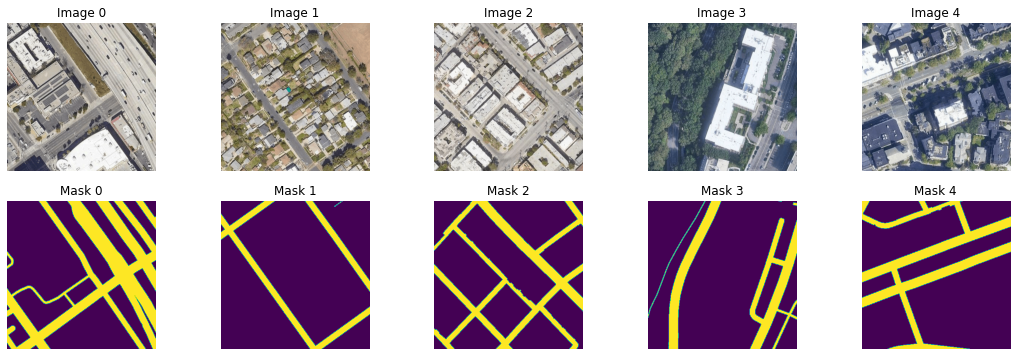

In [4]:
show_first_n(train_images, train_masks, n=5)

# 2. Create a PyTorch `DataLoader`

In [9]:
PATCH_SIZE = 16
CUTOFF = 0.25

def image_to_patches(images, masks=None):
    # takes in a 4D np.array containing images and (optionally) a 4D np.array containing the segmentation masks
    # returns a 4D np.array with an ordered sequence of patches extracted from the image and (optionally) a np.array containing labels
    n_images = images.shape[0]  # number of images
    h, w = images.shape[1:3]  # shape of images
    assert (h % PATCH_SIZE) + (w % PATCH_SIZE) == 0  # make sure images can be patched exactly

    images = images[:,:,:,:3]
    
    h_patches = h // PATCH_SIZE
    w_patches = w // PATCH_SIZE
    
    patches = images.reshape((n_images, h_patches, PATCH_SIZE, w_patches, PATCH_SIZE, -1))
    patches = np.moveaxis(patches, 2, 3)
    patches = patches.reshape(-1, PATCH_SIZE, PATCH_SIZE, 3)
    if masks is None:
        return patches

    masks = masks.reshape((n_images, h_patches, PATCH_SIZE, w_patches, PATCH_SIZE, -1))
    masks = np.moveaxis(masks, 2, 3)
    labels = np.mean(masks, (-1, -2, -3)) > CUTOFF  # compute labels
    labels = labels.reshape(-1).astype(np.float32)
    return patches, labels


def show_patched_image(patches, labels, h_patches=25, w_patches=25):
    # reorders a set of patches in their original 2D shape and visualizes them
    fig, axs = plt.subplots(h_patches, w_patches, figsize=(18.5, 18.5))
    for i, (p, l) in enumerate(zip(patches, labels)):
        # the np.maximum operation paints patches labeled as road red
        axs[i // w_patches, i % w_patches].imshow(np.maximum(p, np.array([l.item(), 0., 0.])))
        axs[i // w_patches, i % w_patches].set_axis_off()
    plt.show()

In [7]:
def np_to_tensor(x, device):
    # allocates tensors from np.arrays
    if device == 'cpu':
        return torch.from_numpy(x).cpu()
    else:
        return torch.from_numpy(x).contiguous().pin_memory().to(device=device, non_blocking=True)

In [11]:
class ImageDataset(torch.utils.data.Dataset):
    def __init__(self, path, device, use_patches=True, resize_to=(400, 400)):
        self.path = path
        self.device = device
        self.use_patches = use_patches
        self.resize_to = resize_to
        self.x, self.y, self.n_samples = None, None, None
        self._load_data()

    def _load_data(self):  # not very scalable, but good enough for now
        self.x = load_all_from_path(os.path.join(self.path, 'images'))[:,:,:,:3]
        self.y = load_all_from_path(os.path.join(self.path, 'groundtruth'))
        if self.use_patches:  # split each image into patches
            self.x, self.y = image_to_patches(self.x, self.y)
        self.x = np.moveaxis(self.x, -1, 1)  # pytorch works with CHW format instead of HWC
        self.n_samples = len(self.x)

    def _preprocess(self, x, y):
        # to keep things simple we will not apply transformations to each sample,
        # but it would be a very good idea to look into preprocessing
        return x, y

    def __getitem__(self, item):
        return self._preprocess(np_to_tensor(self.x[item], self.device), np_to_tensor(self.y[[item]], self.device))
    
    def __len__(self):
        return self.n_samples

In [16]:
from models.baselines.baseline_vanilla_unet import UNet

if torch.cuda.is_available():
    device = 'cuda'
elif torch.backends.mps.is_available():
    device = 'mps'
else:
    device = 'cpu'

train_path = "../data/training/"
val_path = "../data/validation/"

train_dataset = ImageDataset(train_path, device=device)
val_dataset = ImageDataset(val_path, device=device)
train_dataloader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=128, shuffle=True)



  0%|          | 0/134 [00:00<?, ?it/s]

  0%|          | 0/134 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]